The objective of this notebook is to experiments with different parameters for BOW and MNB


## MLFlow configuration

In [53]:
import mlflow
from mlflow.exceptions import RestException

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.search_experiments()

[<Experiment: artifact_location='/home/maldu/dscience/projects/spam_detector/notebooks/experimentation/artifacts/0', creation_time=1733326012211, experiment_id='0', last_update_time=1733326012211, lifecycle_stage='active', name='Default', tags={}>]

In [55]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [56]:
experiment_name = "spam-classifier"

experiment_description = (
    "This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier."
)

experiment_tags = {
    "project_name": "spam-classifier",
    "project_stage": "testing",
    "team": "ml-team",
    "project_quarter": "Q4-2024",
    "mlflow.note.content": experiment_description,
}



try:
    experiment_id = mlflow.create_experiment(name=experiment_name, tags=experiment_tags)
    print(f"Experiment created with ID: {experiment_id}")
except RestException as e:
    if "RESOURCE_ALREADY_EXISTS" in str(e):
        print(f"Experiment '{experiment_name}' already exists.")
        experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    else:
        raise e

print(f"Working with experiment ID: {experiment_id}")

Experiment created with ID: 1
Working with experiment ID: 1


## Datasets

In [57]:
import pandas as pd
from mlflow.models import infer_signature


train = pd.read_csv("../../data/gold/train.csv")
test = pd.read_csv("../../data/gold/test.csv")

X_train = train['features']
y_train = train['target']
X_test = test['features']
y_test = test['target']
signature = infer_signature(X_train, y_train)

/home/maldu/.cache/pypoetry/virtualenvs/spam-detector-P2ybB3t6-py3.10/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


## Pipeline

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    fbeta_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    auc,
    balanced_accuracy_score,
)


pipeline = Pipeline([
        ('vectorizer', CountVectorizer(ngram_range=(1, 1), max_features=2000)),
        ('classifier', MultinomialNB())
    ])
    
pipeline.fit(X_train, y_train)
y_test_pred = pipeline.predict(X_test)

pipeline = Pipeline([
        ('vectorizer', CountVectorizer(ngram_range=(1, 1), max_features=2000)),
        ('classifier', MultinomialNB())
    ])
    
pipeline.fit(X_train, y_train)
y_test_pred = pipeline.predict(X_test)


In [59]:
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {test_accuracy:.2f} ")

Accuracy: 0.97 


Notes: 

As expected our model has a high accuracy that doesn't mean much since the dataset is imbalanced

In [60]:
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

Balanced Accuracy: 0.96


Notes: 

The model is correctly identifying both spam and non-spam messages with a high level of recall.

In [61]:
# F0.5-Score
f0_5_score = fbeta_score(y_test, y_test_pred, beta=0.5)
print(f"F0.5-Score: {f0_5_score:.2f}")

F0.5-Score: 0.85


In [62]:
report = classification_report(y_test, y_test_pred)
print("Classification Report (Test Data):")
print(report)

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       453
           1       0.82      0.95      0.88        63

    accuracy                           0.97       516
   macro avg       0.91      0.96      0.93       516
weighted avg       0.97      0.97      0.97       516



Notes:

- f0.5-score: the metric chosen since I want to give more important to the false positives. A value of 0.85 indicates good performance of the model. 
- Precision: 82% of the predicted positives are true positives. Good performance.
- Recall: 95% of the real positives are true positives. Good performance.
- F1-score: the model is doing a decent job but since the dataset is imbalanced and I want to focus on the false positives, I take it with a grain of salt. 
- Accuracy and macro avg can be ignored.
- Weighted avgs: they also look good but we have to remember that depending on the disbalance of our dataset, these values can hide issues.  

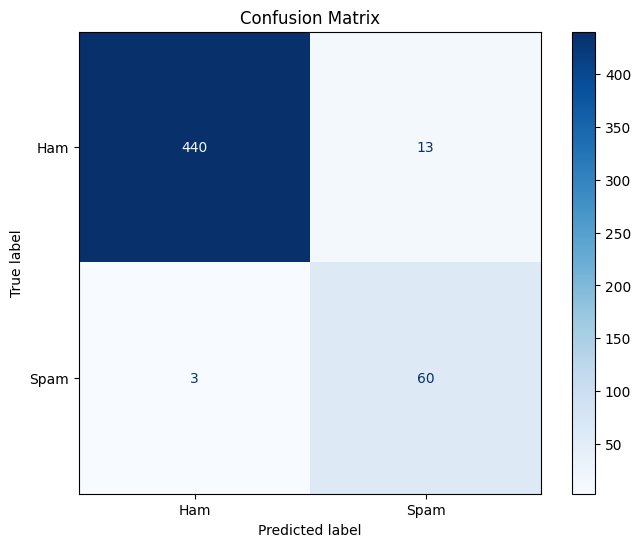

In [63]:
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
matrix_fig, ax = plt.subplots(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=['Ham', 'Spam'])
cm_display.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix")
plt.show()

Notes:

The confusion matrix looks very good.
- 13 e-mails were predicted as SPAM but they were HAM. (these are the ones I will try to minimize)
- 3 e-mails were predicted as HAM but they were SPAM.

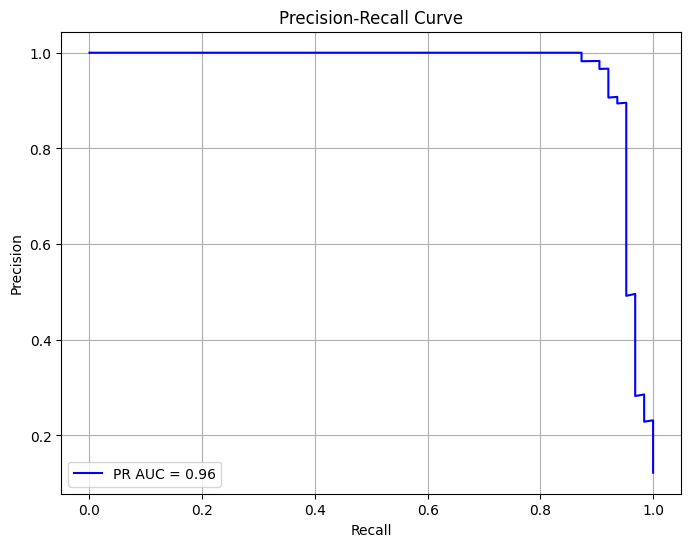

In [64]:
y_test_pred_prob = pipeline.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_test_pred_prob)
pr_auc = auc(recall, precision)

pr_fig, ax = plt.subplots(figsize=(8, 6))  
ax.plot(recall, precision, color='b', label=f'PR AUC = {pr_auc:.2f}')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend(loc="best")
ax.grid(True)
plt.show()


Notes: 

The area under the curve is 0.96 so the model strikes a strong balance between precision and recall across thresholds. The model identifies spam effectively without producing excessive false positives.

## MlFlow tracking

In [65]:
import json
import os
import tempfile
mlflow.set_experiment(experiment_name)
    
with mlflow.start_run(run_name="baseline-model") as run:
    
    mlflow.set_tag("model", "Reference model MultinomialNB + BOW")

    #Datasets
    mlflow.log_param("data_folder", "../../data/gold/")
    mlflow.log_param("train_file", "train.csv")
    mlflow.log_param("test_file", "test.csv")
    
    #BOW and model
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("model_type", "MultinomialNB")
    
    # Metrics
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("balanced_accuracy", balanced_accuracy)
    mlflow.log_metric("f0_5_score", f0_5_score)
    cr = classification_report(y_test, y_test_pred, output_dict=True)
    mlflow.log_metric("accuracy", cr.pop("accuracy"))
    for class_or_avg, metrics_dict in cr.items():
        for metric, value in metrics_dict.items():
            mlflow.log_metric(class_or_avg + '_' + metric,value)
    
    # Figures
    mlflow.log_figure(matrix_fig, "confusion-matrix.png")
    mlflow.log_figure(pr_fig, "precision-recall-curve.png")
    
    # CountVectorizer and MNB
    mlflow.sklearn.log_model(pipeline, "pipeline",signature=signature)
    

    print(f"Pipeline logged to MLflow under run ID {run.info.run_id}")

Pipeline logged to MLflow under run ID 28f92cc806c04d6f959cc16802b838f0
🏃 View run baseline-model at: http://127.0.0.1:5000/#/experiments/1/runs/28f92cc806c04d6f959cc16802b838f0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


Conclusions:

- Clear overfitting 